# Applying GIRAFFE on in silico data

In this notebook, we aim to investigate the performance of GIRAFFE on TODO artificial datasets. These datasets are designed to be representative of the underlying biology, and show that GIRAFFE performs well under those assumptions. We will use PANDA [1], OTTER [2], and the motif as comparisons. 

## 1. Load required packages

We load GIRAFFE and other required packages. PANDA and OTTER are available on netZooPy. Feel free to check [here](https://netzoopy.readthedocs.io/en/latest/install/index.html) for more information about installing netZooPy. 

In [1]:
import giraffe
from netZooPy.otter.otter import otter
from netZooPy.panda.panda import Panda 
import pandas as pd
import numpy as np
import scipy
from scipy import stats
from numpy.random import default_rng
import matplotlib.pyplot as plt
import random

## 3. Recovering ground-truth from projections

We create a new toy dataset. The dimensionality are picked to be coherent with the typical biological scenario. 

In [2]:
TF = 100
G = 500
n = 50

Similarly as before, we need to simulate the ground-truth regulation matrix R. We generate a sparse matrix, where non-zero entries are uniformly sampled in (0, 1). 

In [3]:
def generate_regulation(g, tf) :
    sparsity = 0.2
    rng = default_rng()
    rvs = stats.uniform(loc = 0, scale = 1).rvs
    R = scipy.sparse.random(g, tf, sparsity, random_state = rng, data_rvs = rvs).A
    return R

The motif is computed from the true regulation matrix by corrupting it with random uniform noise. 

In [4]:
def generate_motif(r):
    return r + np.random.uniform(-1, 1, (r.shape[0], r.shape[1]))

We decide that two proteins interact if they co-regulate "many" genes. To pick a proper threshold value, we plot the distribution of the number of co-regulated genes. 

(0.0, 500.0)

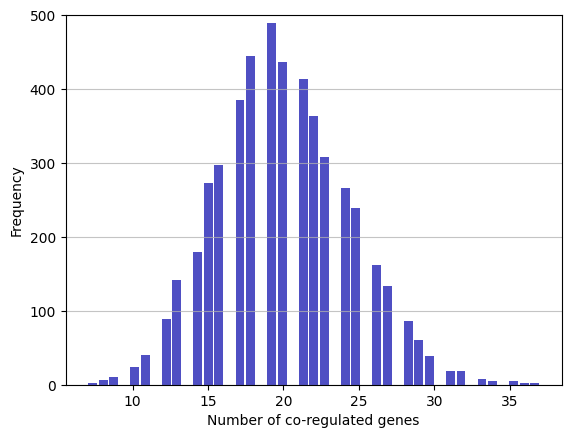

In [6]:
R = generate_regulation(G, TF)

cooperation = []
R[R != 0] = 1
for i in range(TF):
    for j in range(i + 1, TF):
        cooperation.append(R[:, i].dot(R[:, j]))

"The following lines or code are taken from https://realpython.com/python-histograms/ [Accessed on Jan. 13th 2023]"
s, bins, patches = plt.hist(x = cooperation, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha = 0.75)
plt.xlabel('Number of co-regulated genes')
plt.ylabel('Frequency')
maxfreq = s.max()
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

We want a sparse PPI, so we heuristically pick 25 as threshold value (larger than the mean, but small enough to recover enough information). We now construct the PPI network. 

In [7]:
def generate_ppi(R):
    ppi = np.zeros((R.shape[1], R.shape[1]))
    R[R != 0] = 1
    for i in range(R.shape[1]):
        for j in range(R.shape[1]):
            if i == j :
                ppi[i, j] = 1 # By definition
            else :
                if R[:, i].dot(R[:, j]) >= 25:
                    ppi[i, j] = 1
    return ppi

Gene expressioned is sampled from a multi-normal distribution with mean zero and the same covariance as the regulation matrix. 

In [8]:
def generate_expression(C) :
    return np.random.multivariate_normal([0 for i in range(G)], C.T, n).T

Now we have generators for all required data: a ground-truth regulation matrix, a corrupter motif, and a PPI netork. We are ready to put the pieces together in our simulation. 

In [14]:
def simulation() :
    R = generate_regulation(G, TF)
    ppi = generate_ppi(R)
    motif = generate_motif(R)
    expression = generate_expression(R.dot(R.T))

    otter_regulation = otter(motif.T, ppi, np.corrcoef(motif))
    giraffe_oracle_regulation = giraffe.Giraffe(expression, motif, ppi, lam = [0.000001, 5, 50, 1, 1]).get_regulation()
    giraffe_agnostic_regulation = giraffe.Giraffe(expression, motif, ppi).get_regulation()
    motif[motif >= np.quantile(motif, .6)] = 1 # PANDA requires a binary motif
    motif[motif != 1] = 0
    panda_regulation = giraffe.utils.compute_panda_locally(expression, motif, ppi)
    giraffe.utils.plot_auroc(
        R, 
        [otter_regulation.T, giraffe_oracle_regulation, giraffe_agnostic_regulation,panda_regulation, motif], 
        ["OTTER", "GIRAFFE (custom weights)", "GIRAFFE (learned weights)", "PANDA", "Motif"]
    )

Loading motif data ...
  Elapsed time: 0.00 sec.
Loading PPI data ...
Number of PPIs: 1512
  Elapsed time: 0.00 sec.
Calculating coexpression network ...
  Elapsed time: 0.00 sec.
Creating motif network ...
  Elapsed time: 0.02 sec.
Creating PPI network ...
  Elapsed time: 0.00 sec.
Normalizing networks ...
  Elapsed time: 0.01 sec.
Running PANDA algorithm ...
step: 0, hamming: 1.09114454650317
step: 1, hamming: 0.46774770772602287
step: 2, hamming: 0.28926201406229485
step: 3, hamming: 0.20863018427092872
step: 4, hamming: 0.16037791677388985
step: 5, hamming: 0.12753475190869565
step: 6, hamming: 0.10349313963624171
step: 7, hamming: 0.08503005822564987
step: 8, hamming: 0.07039091813956522
step: 9, hamming: 0.05853238137805409
step: 10, hamming: 0.04878771846269452
step: 11, hamming: 0.040711122912071476
step: 12, hamming: 0.033981822005434585
step: 13, hamming: 0.02835640576507249
step: 14, hamming: 0.023646313133809237
step: 15, hamming: 0.01970142772141589
step: 16, hamming: 0.01

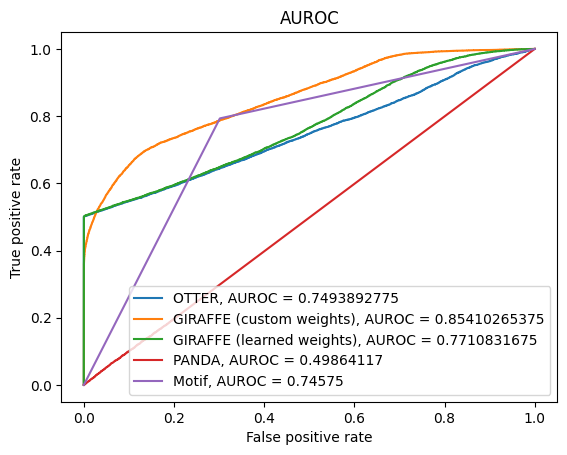

In [15]:
simulation()

We observe that GIRAFFE performs better than the other baselines. Note how GIRAFFE optionally accepts custom weights: this can be tuned (using proper statistical practices) and guide the optimization algorithm to focus on the reconstruction loss, the coherence with the PPI, or the coherence with the co-expression network. If no custom weights are provided, GIRAFFE assigns weights internally using multi-task learning knowledge. 

## References

[1] Glass K, Huttenhower C, Quackenbush J, Yuan GC. "Passing Messages Between Biological Networks to Refine Predicted Interactions", PLoS One, 2013 May 31;8(5):e64832

[2] Weighill, Deborah, et al. "Gene regulatory network inference as relaxed graph matching." Proceedings of the... AAAI Conference on Artificial Intelligence. AAAI Conference on Artificial Intelligence. Vol. 35. No. 11. NIH Public Access, 2021.